<img src="skoltech_logo.png" alt="Skoltech" width=80% height=60% style="padding-right:80px;"/>
<h1 style="color:#333333; text-align:center; line-height: 0;">Reinforcement Learning</h1>
<h5 style="color:#333333; text-align:center;">Course MA030422</h5>

<h2 style="color:#A7BD3F;">Homework 3</h2>

***

In the previous homework, you learned about linear approximation in RL and how to apply it to continuous state and action space environments, specifically ENDI from Rcognita. In particular, you implemented a *Trajectory-Based Value Iteration* algorithm that utilized least-squares optimization to find the optimal policy and Q functions.

### Goal of this homework

In this homework, we will be expanding our understanding of approximation methods for RL by studying different approaches to estimating the optimal policy and value-functions for the ENDI environment. In particular, we will examine and implement 5 different algorithms, all of which are based on Monte-Carlo prediction.

### Components

* Relevant concepts 
* Exericse 1 - Monte-Carlo methods
    * Problem 1.1 - 10 points
* Exericse 2 - Neural Networks with MC
    * Problem 2.1 - 5 points
    * Problem 2.2 - 5 points
* Exericse 3 - TD Learning for Q-function optimization
    * Problem 3.1 - 10 points
    * Problem 3.2 - 5 points

Total points: 35

<h2 style="color:#A7BD3F;">Imports and Autograder</h2>

***

In [1]:
from rcognita import EndiSystem, EndiControllerBase, Simulation, AnswerTracker
import numpy as np
import scipy as sp

# torch
import torch
import torch.nn as nn
import torch.optim as optim

# misc
from tqdm import tqdm
import os
from IPython.display import HTML, clear_output

### <font color="orange">Auto-grading</font>
Run this cell to track your answers.

In [2]:
### GRADING DO NOT MODIFY
hw3_answers = AnswerTracker()

<h2 style="color:#A7BD3F;">Relevant concepts</h2>

Let's refresh on the relevant concepts covered in the ensuing sections:

### Off-line learning v.s. On-line learning

Off-line:
* Offline RL methods are applicable if data can be obtained in advance and in bulk.
* This means that the dataset is acquired in a prior phase (to the training phase of the model). 
    * In other words: model training happens separately from model evaluation.

On-line:
* Online learning is an approach that ingests data one observation at a time, as the data comes in from the environment.
* Online RL algorithms learn a solution by interacting with the system, and can therefore be applied even when data is not available in advance.
* In other words, training and evaluation happen sequentially in a single simulation


### On-policy learning v.s. off-policy learning

On-policy:
* In on-policy learning, we 1) start with a single policy 2) use it to determine next actions and states, and 3) at each time step (interaction with the environment), we optimize this policy to improve it. Usually, policy optimization involves stochastic methods for exploration, either in action sampling or introducing disturbance into the environment.

Off-policy:
* Off-policy entails the use two policies, whereby one policy (the "behaviour" policy) is used for taking steps and collecting samples in order to optimize the other ("target") policy. Usually, in this case the behaviour policy is used to enhance how exploration is done, and its key purpose is to collect samples to improve the target policy.

In Sutton's words, page 110 <sup>[1]</sup>:
> Recall that the distinguishing feature of on-policy methods is that they estimate the value of a policy while using it for control. In off-policy methods these two functions are separated. The policy used to generate behavior, called the behavior policy, may in fact be unrelated to the policy that is evaluated and improved, called the target policy. An advantage of this separation is that the target policy may be deterministic (e.g., greedy), while the behavior policy can continue to sample all possible actions.

<h2 style="color:#A7BD3F;">Exercise 1 - Monte-Carlo methods</h2>

***

In chapter 5 of the class text<sup>[1]</sup>, Sutton describes Monte Carlo (MC) methods-- "used for estimating value functions and discovering optimal policies". One of the benefits of MC methods comes from the fact that they do not require knowledge of the environment:
> Monte Carlo methods require only experience—sample sequences of states, actions, and rewards from actual or simulated interaction with an environment. Learning from actual experience is striking because it requires no prior knowledge of the environment’s dynamics, yet can still attain optimal behavior.

Sutton clarifies that the MC methods presented in chapter 5 "[are used for solving] reinforcement learning problem based on **averaging sample returns**". Note that these methods are:
> * Only incremental in an episode-by-episode sense, **but not in a step-by-step (online) sense.**
> * Meaning, only on the completion of an episode are value estimates and policies changed.

### <font color="blue">Problem 1.1 - Algorithm 1</font>

In this problem we will be implementing a MC method for policy estimation that operates differently from Sutton's description above. Its difference lies in that it does not "average returns for each state–action pair" after each episode, but instead sums returns for each state-action pair over a trajectory for each time step of an episode, using randomly generated actions.

<img src="MCTBVI.png" width=70% height=70% />

This algorithm is denoted as **MCTBVI**. To reiterate, it is:
* MC-based prediction
* On-line
* On-Policy (although for the purposes of simplicity, we don't update the value function).

#### 🎯 Task 1 - implement the algorithm above in the code below. Hints:
* Work method by method
* Fill in the code designated by comments

In [33]:
agent1.f_max


    Class denoting the RL environment.

    ----------
    Parameters
    ----------

    dim_state : int
        dimension of state vector
        x_t = [x_c, y_c, alpha, upsilon, omega]
    
    dim_input : int
        * dimension of action vector
        * u_t = [F, M]
    
    dim_output : int
        * dimension of output vector
        * x_t+1 = [x_c, y_c, alpha, upsilon, omega]
    
    dim_disturb : int
        * dimension of disturbance vector
        * actuator disturbance that gets added to F and M
    
    initial_x : int
        * initial x coordinate of robot
    
    initial_y : int
        * initial x coordinate of robot
    
    m : int
        * m = robot's mass
    
    I : int
        * I = moment of inertia about the vertical axis
    
    f_min, f_max, m_min, m_max : all int
        * control bounds
    
    f_man : int
        * manual control variable for pushing force
    
    m_man: int
        * manual control variable for steering/turning torque
    
    is

True

In [34]:
class MCTBVI(EndiControllerBase):
    def __init__(self, system, horizon_length=10, n_actions=10, **kwargs):
        super(MCTBVI, self).__init__(system, **kwargs)
        self.ctrl_mode = 3
        self.gamma = 0.95
        self.x_buffer = self.y_buffer
        self.horizon_length = horizon_length
        self.initial_state = system.system_state
        self.control_bounds = system.control_bounds
        self.n_actions = n_actions

    def _sample_actions(self, u_curr, n_actions):
        """ Sample random actions

            Description: given an current action `u_curr`, samples `n_actions` random actions adds them to the current action. Then clips action matrix to within the bounds specified by `control_bounds`.

            Args:
                u_curr : int
                    * current action/control

                n_actions : int
                    * number of actions to sample

            Returns:
                u_tile : float matrix
                    * matrix of actions

        """
        u_tile = np.tile(u_curr, (n_actions, 1))
        
        for i in range(n_actions):
            # sample force from random uniform distribution (hint: use np.random.uniform)
            f = np.random.uniform(low=self.f_min,high=self.f_max)
            
            # sample turning torque (m) from random uniform distribution (hint: use np.random.uniform)
            m = np.random.uniform(low=self.m_min, high=self.m_max)
            change_in_u = np.array((f,m))
            u_tile[i] = u_tile[i] + change_in_u
            
            for j, value in enumerate(u_tile[i]):
                u_tile[i,j] = np.clip(value, self.control_bounds[j, 0], self.control_bounds[j, 1])
#             print('u_tile.shape',u_tile.shape)
        return u_tile

    def _policy_mc(self, x_input):
        """ Monte Carlo Policy

            Description: returns an action given a state

            Args:
                x_input : 5-d float vector
                    * state

            Returns:
                best_action : 2-d float vector
                    * action/control

        """

        # Line 4: sample 10 actions
        sampled_u = self._sample_actions(self.u_curr, self.n_actions)
#         print('sampled_u',sampled_u.shape)
        # create empty np container to store action values
        action_values = np.empty(sampled_u.shape[0])

        # Line 5: loop through every action
        for i, u in enumerate(sampled_u):
#             print('u',u)
            # tile the action across a horizon (hint: use np.tile)
            u_trajectory = np.tile(u, (self.horizon_length, 1))
#             print('u_trajectory',u_trajectory.shape)

            # create empty np container to store states for each step of an action
            x_trajectory = np.empty([u_trajectory.shape[0], x_input.shape[0]])
            
#             print('x_trajectory.shape',x_trajectory.shape)
            # set the starting state
            x_trajectory[0, :] = x_input
            x = x_input

            # take steps with the current action
            for k in range(1, self.horizon_length):
                x = x + self.step_size * self.sys_dynamics(None, x, u, self.m, self.I, self.dim_state, self.is_disturb)

                x_trajectory[k, :] = x

            # Line 6: calculate discounted return (hint: use _value_function)
            discounted_return = self._value_function(u_trajectory, x_trajectory, self.horizon_length)
            
            # assign discounted return to current action in `action_values`
            action_values[i] = discounted_return
#             print('action values', action_values)
#             print()
#             print('i:', i)
        # Line 8: select best action id (hint: use np.argmin)
        idx = np.argmin(action_values)

        # Line 8: select best action
        best_action = sampled_u[idx]

        return best_action

    def _value_function(self, u_container, x_container, length):
        """ Calculate discounted return over a horizon

            Args:
                u_container : float matrix
                    * matrix of actions

                x_container : float matrix
                    * matrix of states

                length : int
                    * iteration end interval

            Returns:
                J : float
                    * sum of discounted return

        """
        J = 0

        for k in range(1, length):
            x = x_container[k - 1, :]
            u = u_container[k - 1, :]
            x_next = x_container[k, :]
            u_next = u_container[k, :]

            J += self.gamma**k * self.running_cost(x, u)

        return J

    def compute_action(self, t, x):
        """ Compute next action

            Description: called by simulation to take steps through the env

            Args:
                t : float
                    * time

                x : 5-d float vector
                    * state

        """

        time_since_last_action = t - self.ctrl_clock

        if time_since_last_action >= self.sample_time:
            # select current action given state x (hint: call _policy_mc on current state x)
            self.u_curr = self._policy_mc(x)

            return self.u_curr

        else:
            return self.u_curr

    def running_cost(self, x, u):
        """ Cost function aka reward function aka utility function

            Args:
                x : 5-d float vector
                    * state

                u : 2-d float vector
                    * control

        """

        r = (x @ self.Q @ x) + (u @ self.R @ u)

        return r

### Run simulation

In [35]:
sys = EndiSystem()
agent1 = MCTBVI(sys, sample_time=0.3, horizon_length=10, t1=30)
sim = Simulation(sys, agent1)
sim.run_simulation(n_runs=2, 
                is_visualization=False, 
                exit_py_on_finish=False, 
                show_summary_stats=True, 
                print_statistics_at_step=False)

... Running - run 1...
... Running - run 2...
Total runs for each controller: 2
Statistics for controller 1:
            - Mean of running cost: 57.85
            - Mean of velocity: -0.23
            - SD of running cost: 141.12
            - SD of velocity: 0.55
            - SD of turning angle: 57.85
            - SD L2-norm: 2.13
            - Final L2-norm: 0.04
            - RMSE of Trajectory: 3.365
                


### <font color="orange">Auto-grading</font>
Run this cell to track your answers and to save your answer for problem 1.1. 

In [36]:
x,  = sim.final_statistics 
x

(57.85, -0.23, 141.12, 0.55, 57.85, 0.04, 2.13, 3.365)

In [37]:
### GRADING DO NOT MODIFY
statistics, = sim.final_statistics

hw3_answers.record('problem_1-1', 
    {'mean_rc': statistics[0],
    'mean_velocity': statistics[1], 
    'sd_rc': statistics[2],
    'sd_velocity': statistics[3],
    'sd_alpha': statistics[4],
    'final_l2_norm': statistics[5],
    'sd_l2_norm': statistics[6],
    'rmse_l2_norm': statistics[7]})

<h2 style="color:#A7BD3F;">Exercise 2 - Neural Networks with MC</h2>

MC prediction methods can be combined with deep learning by serving as trainers (aka supervisors) of neural networks. In this exercise, we'll review such implementions in both *off-line* and *on-line* learning cases.

### <font color="blue">Problem 2.1 - Algorithm 2</font>

Firstly, let's examine how the MC policy from problem 1.1 can be used as a supervisor for a neural network-based policy in the case of an <font color="8F00FF">**off-line**</font> and <font color="8F00FF">**off-policy**</font> method.

This algorithm consists of two parts:
* The trainer agent
* The actor agent

#### How does it work

The purpose of the trainer agent is solely to train the NN with an MC policy. It does so in two steps:
1. Plays out a full episode taking steps with an MC policy. It saves all of its actions and states into buffers.
2. Then, it trains the NN with the actions and states stored in the buffers.

Afterwards the actor agent performs step 3:
3. It uses the trained NN policy to play an episode

There are two important takeaways as far as RL taxonomy goes:
* Because the training (steps 1 and 2) happens separately from model evaluation (step 3), this algorithm is an example of <font color="8F00FF">**off-line learning**</font>.
* Because the NN policy is not concurrently optimized **and** used for step-taking during the simulation, this is an example of an <font color="8F00FF">**off-policy** algorithm</font>.

#### 🎯 Task 1 - implement the NN trainer in the code below

Hints:
* Work method by method
* Fill in the code designated by comments

### <font color="#ba03fc">Step 1</font>

#### First, define neural network (for policy approximation)
* This is done for you, there's nothing to do in this part.

In [38]:
class PolicyNN(nn.Module):
    def __init__(self, obs_size=5, hidden_size=128, n_actions=2):
        super(PolicyNN, self).__init__()
        self.linear1 = torch.nn.Linear(obs_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        self.linear3 = torch.nn.Linear(hidden_size, n_actions)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = self.linear3(x)
        return x

#### Next, inherit MCTBVI class and create trainer agent

In [39]:
class OfflineTrainerAgent(MCTBVI):
    def __init__(self, system, horizon_length=10, n_epochs=1000, **kwargs):
        super(OfflineTrainerAgent, self).__init__(system, **kwargs)
        self.save_path = os.getcwd() + "/policy.pth"

        self.policy_nn = PolicyNN()
        self.criterion = torch.nn.SmoothL1Loss()
        self.optimizer = optim.Adam(params=self.policy_nn.parameters(), lr=0.0005)
        
        self.u_trajectory = []
        self.x_trajectory = []
        self.n_epochs = n_epochs

    def train_network(self, overwrite_pth=True, print_last_batch=False):
        """ Train neural network from buffers

            Args:
                overwrite_pth : boolean
                    * overwrite model weights file (titled policy.pth)?

                print_last_batch : boolean
                    * for debugging, do you want to see how the preds and targets line up for the last training batch?

            Returns:
                None 

        """
        if overwrite_pth is True or not os.path.exists(self.save_path):
            print("Training neural net...")

            try:
                # stack trajectories into np form
                u = np.vstack(self.u_trajectory)
                x = np.vstack(self.x_trajectory)
                dataset = torch.as_tensor(np.concatenate((x,u), axis=1), dtype=torch.float32)
            
            except:
                print("Buffers not filled because simulation was not run before training.")
                sys.exit()

            # create dataloader for pytorch
            self.trainloader = torch.utils.data.DataLoader(dataset, 256, shuffle=False)

            for epoch in tqdm(range(self.n_epochs)):
                running_loss = 0.0
                
                # for in trainloader
                for batch in self.trainloader:
                    # zero out gradients in optimizer
                    self.optimizer.zero_grad()

                    # specify states of batch (hint: first 5 column vectors of batch)
                    states = batch[:,:5]

                    # specify target actions of batch (hint: last 2 column vectors of batch)
                    target_actions = batch[:,5:]
                    # predict actions for batch using policy network
                    predicted_action = self.policy_nn.forward(states)

                    # calculate loss
                    self.loss = self.criterion(predicted_action, target_actions)

                    # calculate gradients of loss w.r.t all parameters in computational graph
                    self.loss.backward()

                    # update weights of neural network
                    self.optimizer.step()

                    # increment running loss
                    running_loss += self.loss

            if print_last_batch is True:
                print(torch.cat((predicted_action, target_actions), dim=1))

            torch.save(self.policy_nn.state_dict(), self.save_path)
            print("...Policy saved.")

        else:
            print("Skipping training, policy file exists and overwrite is False.")
    
    def compute_action(self, t, x):
        time_since_last_action = t - self.ctrl_clock

        if time_since_last_action >= self.sample_time:
            
            self.u_curr = self._policy_mc(x)

            # fill buffers for training
            self.u_trajectory.append(self.u_curr)
            self.x_trajectory.append(x)

            return self.u_curr

        else:
            return self.u_curr

#### Run trainer agent simulation to fill buffers

In [40]:
sys = EndiSystem()
trainer = OfflineTrainerAgent(sys, sample_time=0.3, horizon_length=10, t1=30)
sim = Simulation(sys, trainer)
sim.run_simulation(n_runs=1, 
                is_visualization=False, 
                exit_py_on_finish=False,  
                show_summary_stats=True, 
                print_statistics_at_step=False)

... Running - run 1...
Total runs for each controller: 1
Statistics for controller 1:
            - Mean of running cost: 60.05
            - Mean of velocity: -0.2
            - SD of running cost: 146.01
            - SD of velocity: 0.5
            - SD of turning angle: 60.05
            - SD L2-norm: 2.18
            - Final L2-norm: 0.06
            - RMSE of Trajectory: 2.958
                


<IPython.core.display.Javascript object>


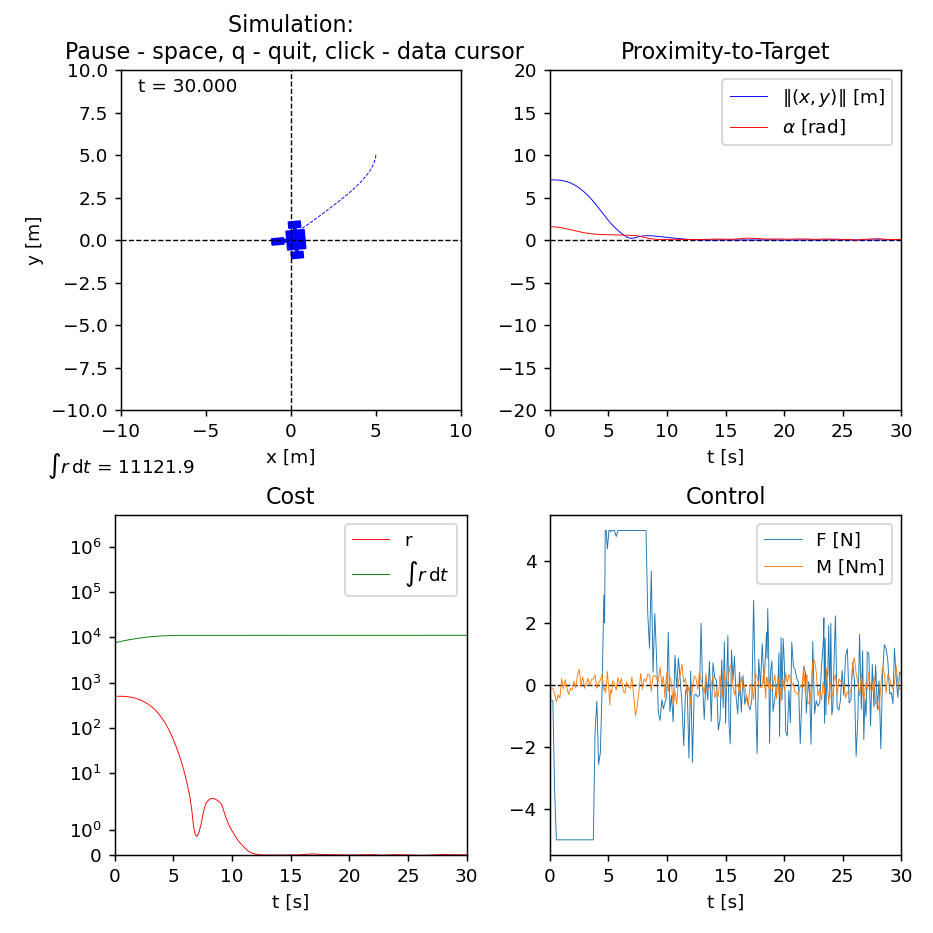

<IPython.core.display.HTML object>

In [41]:
#Uncomment to visualize
%matplotlib notebook
HTML(sim.run_simulation(n_runs=2, fig_width=7, fig_height=7))

### <font color="#ba03fc">Step 2 - </font> Run NN training 

Note that this operation saves the NN weights to a file called `policy.pth`.

In [42]:
trainer.train_network()

  1%|          | 8/1000 [00:00<00:12, 78.92it/s]

Training neural net...


100%|██████████| 1000/1000 [00:09<00:00, 102.93it/s]

...Policy saved.


### <font color="#ba03fc">Step 3</font>

#### Finally, implement the NN actor agent in the code below
* This *actor* will play an episode using the NN as the policy function.
* There's nothing for you to do on this one, just execute the code and make sure you understand why it works

In [43]:
class OfflineActorAgent(EndiControllerBase):
    def __init__(self, system, **kwargs):
        super(OfflineActorAgent, self).__init__(system, **kwargs)
        self.ctrl_mode = 3

        self.policy_nn = PolicyNN()
        self.save_path = os.getcwd() + "/policy.pth"

        try:
            # load model weights from policy.pth
            self.policy_nn.load_state_dict(torch.load(self.save_path))

            # set the NN to evaluation mode
            self.policy_nn.eval()
            print("Policy loaded.")
        except:
            print("Failed to load policy.")


    def compute_action(self, t, x):
        time_since_last_action = t - self.ctrl_clock

        if time_since_last_action >= self.sample_time:
            
            with torch.no_grad():
                x = torch.FloatTensor(x)
                self.u_curr = self.policy_nn(x).detach().numpy()

            return self.u_curr

        else:
            return self.u_curr

#### Now run the actor agent to see how the NN policy performs

In [44]:
sys = EndiSystem()
agent2 = OfflineActorAgent(sys, sample_time=0.3, t1=30)
sim = Simulation(sys, agent2)
sim.run_simulation(n_runs=2, 
                is_visualization=False, 
                exit_py_on_finish=False,  
                show_summary_stats=True, 
                print_statistics_at_step=False)

Policy loaded.
... Running - run 1...
... Running - run 2...
Total runs for each controller: 2
Statistics for controller 1:
            - Mean of running cost: 60.76
            - Mean of velocity: -0.23
            - SD of running cost: 144.28
            - SD of velocity: 0.53
            - SD of turning angle: 60.76
            - SD L2-norm: 2.19
            - Final L2-norm: 0.0
            - RMSE of Trajectory: 3.373
                


#### Option to visualize

<IPython.core.display.Javascript object>


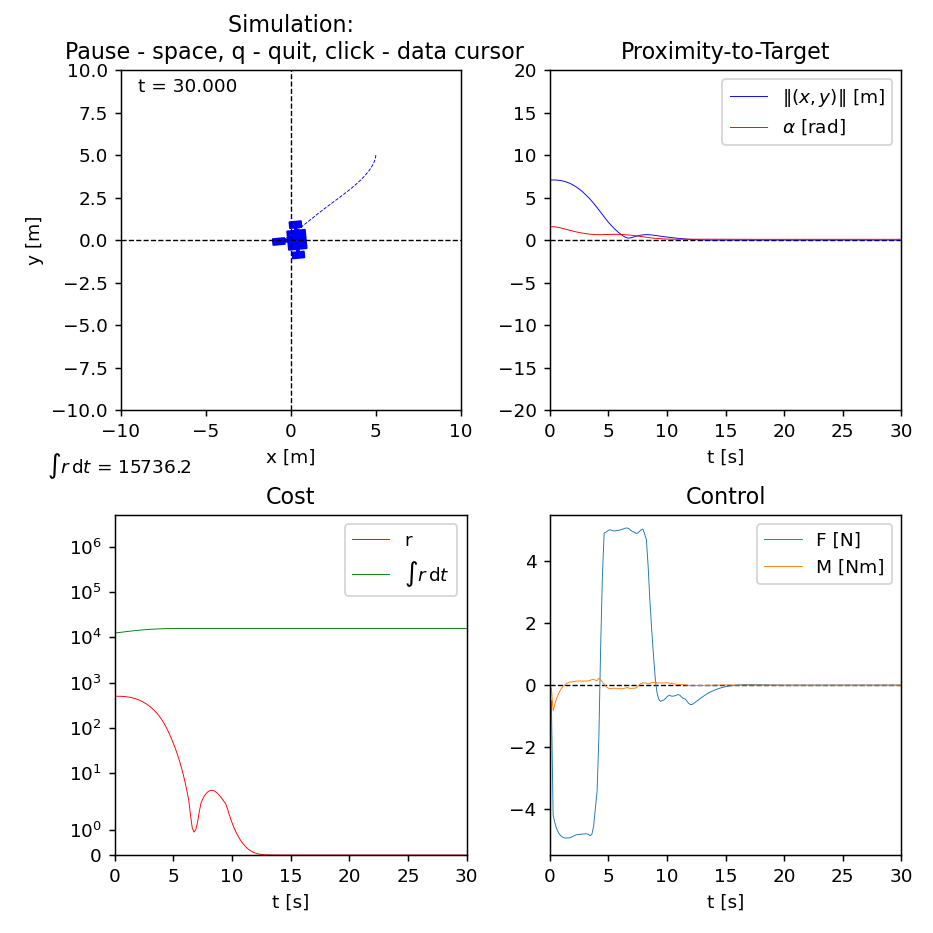

<IPython.core.display.HTML object>

In [45]:
# # Uncomment to visualize
%matplotlib notebook
HTML(sim.run_simulation(n_runs=2, fig_width=7, fig_height=7, show_annotations=True))

In [47]:
sim.final_statistics

[(60.76, -0.23, 144.28, 0.53, 60.76, 0.0, 2.19, 3.373)]

### Analysis

The trainer agent played 2 episodes, recorded $x$ and $u$ into its buffers, and then trained the NN policy to learn the best (lowest cost) $u$ for a given $x$. If you compare the final L2-norm and standard deviations of the L2-norms for both trainer and actor, you'll see they are very close. 

In conclusion, the simulation of the actor shows us that:
* a) the MC policy has been memorized by the NN
* b) quickly converges to (0,0)

### <font color="orange">Auto-grading</font>
Run this cell to track your answers and to save your answer for problem 2.1. 

In [48]:
### GRADING DO NOT MODIFY
statistics, = sim.final_statistics

hw3_answers.record('problem_2-1', 
    {'mean_rc': statistics[0],
    'mean_velocity': statistics[1], 
    'sd_rc': statistics[2],
    'sd_velocity': statistics[3],
    'sd_alpha': statistics[4],
    'final_l2_norm': statistics[5],
    'sd_l2_norm': statistics[6],
    'rmse_l2_norm': statistics[7]})

### <font color="blue">Problem 2.2 - Algorithm 3</font>

In this problem we will review an <font color="8F00FF">**on-line**</font> and <font color="8F00FF">**on-policy**</font> version of the same algorithm above. 

#### 🎯 Task 1 - implement the algorithm below in the lines specified by the comments

In [50]:
class NNOnlineMC(MCTBVI):
    def __init__(self, system, horizon_length=10, num_iter = 30, **kwargs):
        super(NNOnlineMC, self).__init__(system, **kwargs)
        self.ctrl_mode = 3
        self.horizon_length = horizon_length
        self.control_bounds = system.control_bounds
        self.gamma = 0.95
        self.num_iter = num_iter

        self.save_path = os.getcwd() + "/policy_online.pth"

        self.policy_nn = PolicyNN()
        self.criterion = torch.nn.MSELoss()
        self.optimizer = optim.Adam(params=self.policy_nn.parameters(), lr=0.0005)
    
    def _policy_iteration(self, x, u_target):
        xt = torch.tensor(x, dtype=torch.float32)
        u_target = torch.tensor(u_target, dtype=torch.float32)

        # loop through a number of training iterations
        for i in range(self.num_iter):
            # policy evaluation step
            # calculate u_pred
            u_pred = self.policy_nn.forward(xt)
            # calcuclate loss between u_pred and u_target
            loss = self.criterion(u_target, u_pred)

            # policy improvement
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return u_pred.detach().numpy()

    def compute_action(self, t, x):
        time_since_last_action = t - self.ctrl_clock

        if time_since_last_action >= self.sample_time:
            u_target = self._policy_mc(x)
            self.u_curr = self._policy_iteration(x, u_target)

            return self.u_curr

        else:
            return self.u_curr

### Run simulation

In [51]:
sys = EndiSystem()
agent3 = NNOnlineMC(sys, sample_time=0.3, horizon_length=10, num_iter=30, t1=22)
sim = Simulation(sys, agent3)
sim.run_simulation(n_runs=3, 
                is_visualization=False, 
                exit_py_on_finish=False,  
                show_summary_stats=True, 
                print_statistics_at_step=False)

... Running - run 1...
... Running - run 2...
... Running - run 3...
Total runs for each controller: 3
Statistics for controller 1:
            - Mean of running cost: 81.24
            - Mean of velocity: -0.33
            - SD of running cost: 160.82
            - SD of velocity: 0.61
            - SD of turning angle: 81.24
            - SD L2-norm: 2.4
            - Final L2-norm: 0.02
            - RMSE of Trajectory: 3.324
                


#### Option to visualize

<IPython.core.display.Javascript object>


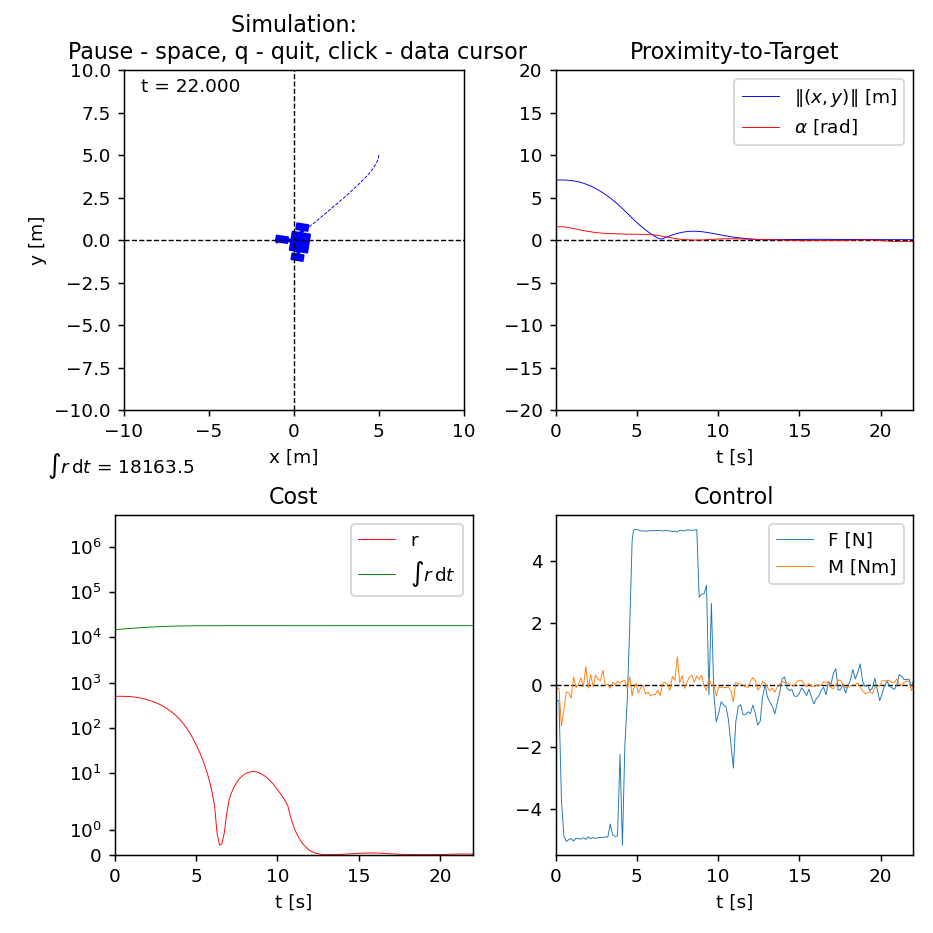

<IPython.core.display.HTML object>

In [52]:
# # Uncomment to visualize
%matplotlib notebook
HTML(sim.run_simulation(n_runs=2, fig_width=7, fig_height=7))

### <font color="orange">Auto-grading</font>
Run this cell to track your answers and to save your answer for problem 1.1. 

In [53]:
### GRADING DO NOT MODIFY
statistics, = sim.final_statistics

hw3_answers.record('problem_2-2', 
    {'mean_rc': statistics[0],
    'mean_velocity': statistics[1], 
    'sd_rc': statistics[2],
    'sd_velocity': statistics[3],
    'sd_alpha': statistics[4],
    'final_l2_norm': statistics[5],
    'sd_l2_norm': statistics[6],
    'rmse_l2_norm': statistics[7]})

<h2 style="color:#A7BD3F;">Exercise 3 - TD Learning</h2>

***
Let's start this exercise by reviewing temporal difference learning from chapter 6 in the class text. What is the difference between TD and MC? <sup>[1]</sup>:
> Both TD and Monte Carlo methods use experience to solve the prediction problem. Given some experience following a policy $\pi$, both methods update their estimate $v_{\pi}$ for the nonterminal states $S_t$ occurring in that experience. Roughly speaking, Monte Carlo methods wait until the **return** following the visit is known, then use that return as a target for $V(S_t)$.


Sutton continues on page 120 <sup>[1]</sup>:
<blockquote>
Whereas Monte Carlo methods must wait until the end of the episode to determine the increment to $V(S_t)$ (only then is $G_t$ known), TD methods need to wait only until the next time step. At time $t + 1$ they immediately form a target and make a useful update using the observed reward $R_{t+1}$ and the estimate $V(S_{t+1})$.

The simplest TD method makes the update: 
$$V\left(S_{t}\right) \leftarrow V\left(S_{t}\right)+\alpha\left[R_{t+1}+\gamma V\left(S_{t+1}\right)-V\left(S_{t}\right)\right]$$

immediately on transition to $S_{t+1}$ and receiving $R_{t+1}$. In effect, the target for the Monte Carlo update is $G_t$, whereas the target for the TD update is $R_{t+1}$ + $V(S_{t+1})$. This TD method is called TD(0), or one-step TD, because it is a special case of the $TD(\cdot)$ and n-step TD methods developed in Chapter 12 and Chapter 7. The box below specifies TD(0) completely in procedural form.

<img src="sutton_120.png" width=70% height=70% />
    
Roughly speaking, Monte Carlo methods use an estimate of (6.3) as a target, whereas DP methods use an estimate of (6.4) as a target. The Monte Carlo target is an estimate because the expected value in (6.3) is not known; a sample return is used in place of the real expected return. The DP target is an estimate not because of the expected values, which are assumed to be completely provided by a model of the environment, but because $V(S_{t+1})$ is not known and the current estimate, $V(S_{t+1})$, is used instead. 

The TD target is an estimate for both reasons: it samples the expected values in (6.4) and it uses the current estimate V instead of the true $v_{\pi}$. Thus, TD methods combine the sampling of Monte Carlo with the bootstrapping of DP. As we shall see, with care and imagination this can take us a long way toward obtaining the advantages of both Monte Carlo and DP methods.
</blockquote>

### <font color="blue">Problem 3.1 - Sarsa</font>

In the first problem of exercise 3 we will examine Sarsa. It is an <font color="8F00FF">**on-policy**</font> TD method described by Sutton on page 129 <sup>[1]</sup>. Sutton uses the following outline for Sarsa:
    
<img src="sarsa_sutton.png" width=75% height=75% />

❗Note the action-value update in the diagram above. The purpose of this update applies to **discrete state and action-space environments** (aka tabular learning) where action-values $Q(s,a)$ need to be stored, updated, and retrieved to find the optimal policy in each episode.

➡️ In our case, we are applying Sarsa to a **continuous state and action space** env (ENDI) using a NN as an approximator of the Q-function. Therefore, we will be implementing a version of Sarsa based exclusively on minimizing TD, which works for function approximation, gradient updates, and approximate dynamic programming algorithms:

<img src="SarsaC.png" width=70% height=70% />

Notice that the temporal difference calculation on line 7 ($\delta$) is identical to that of Sutton's version for finite MDPs. 

The primary difference between this algorithm and Sutton's is that in our version, Q-values are approximated rather than calculated/updated from tabular lookups. Therefore, we update the **Q-function** rather than Q-values, and we do so by minimizing TD with respect to the weights/parameters of the Q-function.

#### 🎯 Task: implement the code specified by the comments. You only need to update:
* `_sum_q_over_traj` method
* `_temporal_diff` method

Importantly:
* the other methods should be familiar to you from above
* the `policy_mc` method is nearly identical to that seen above - **however** it now implements an epsilon greedy policy.
* Notice that we are using a fairly large epsilon: `0.3`
* Regarding the Q-function neural net:
    * Notice that we pass `self.linear3(x)` to an exponential function to ensure that our output values are always positive, since Q must be >= 0.

In [60]:
class QNN(nn.Module):
    def __init__(self, obs_size=7, hidden_size=32):
        super(QNN, self).__init__()
        self.linear1 = torch.nn.Linear(obs_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        self.linear3 = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.tanh(self.linear1(x))
        x = torch.tanh(self.linear2(x))
        x = torch.exp(self.linear3(x))
        return x

class SARSA(EndiControllerBase):
    def __init__(self, system, horizon_length=10, epsilon=0.3, **kwargs):
        super(SARSA, self).__init__(system, **kwargs)
        self.ctrl_mode = 3
        self.horizon_length = horizon_length
        self.control_bounds = system.control_bounds
        self.gamma = 0.95
        self.alpha = 0.5
        self.epsilon = epsilon
        self.n_actions = 10

        self.q_fn = QNN()
        self.optimizer = optim.SGD(params=self.q_fn.parameters(), lr=0.005)

        R = np.diag([0, 0])
        Q = np.diag([10, 10, 1, 0, 0])
        self.R_tensor = torch.tensor(R, dtype=torch.float32)
        self.Q_tensor = torch.tensor(Q, dtype=torch.float32)

    def print_nn_params(self):
        print(list(self.q_fn.parameters())[0])
    
    def _sample_single_action(self):
        f = np.random.uniform(-5, 5)
        m = np.random.uniform(-1, 1)
        action = np.array((f,m))
        
        for i in range(self.dim_input):
            action[i] = np.clip(action[i], self.control_bounds[i, 0], self.control_bounds[i, 1])

        return action

    def _sample_actions(self, existing_u, n_actions):
        u_tile = np.tile(existing_u, (n_actions, 1))
        
        for i in range(n_actions):
            f = np.random.uniform(-5, 5)
            m = np.random.uniform(-1, 1)
            change_in_u = np.array((f,m))
            u_tile[i] = u_tile[i] + change_in_u
            
            for j, value in enumerate(u_tile[i]):
                u_tile[i,j] = np.clip(value, self.control_bounds[j, 0], self.control_bounds[j, 1])

        return u_tile
    
    def _policy_mc(self, x_input):
        sampled_u = self._sample_actions(self.u_curr, self.n_actions)
        action_values = np.empty(self.n_actions)

        for i in range(self.n_actions):
            u_trajectory = np.tile(sampled_u[i,:], (self.horizon_length, 1))
            x_trajectory = np.zeros([self.horizon_length, self.dim_output])
            x_trajectory[0, :] = x_input
            x = x_input

            for k in range(1, self.horizon_length):
                x = x + self.step_size * self.sys_dynamics(None, x, u_trajectory[k - 1, :], self.m, self.I, self.dim_state, self.is_disturb)

                x_trajectory[k, :] = x

            u_trajectory = torch.as_tensor(u_trajectory).float()
            x_trajectory = torch.as_tensor(x_trajectory).float()

            q_over_traj = self._sum_q_over_traj(u_trajectory, x_trajectory, self.horizon_length)
            action_values[i] = q_over_traj.item()

        idx = np.argmin(action_values)
        best_action = sampled_u[idx]

        # epsilon greedy policy
        if torch.rand(1).item() > self.epsilon:
            return best_action, None

        else:
            rand_action = self._sample_single_action()

            return rand_action, best_action


    def _sum_q_over_traj(self, u_container, x_container, length):
        sum_q = 0

        for k in range(1, length):
            x = x_container[k - 1, :]
            u = u_container[k - 1, :]
            x_next = x_container[k, :]
            u_next = u_container[k, :]
            z = torch.cat((x_next, u_next))

            # calculate q_value: Q(s,a) = R(x,u) + (gamma^k)*Q(x_t+1, u_t+1)
            q_value = self.running_cost_tensors(x,u)+(self.gamma**k) * self.q_fn(z)
            sum_q += q_value

        return sum_q

    def _take_action(self, x, u):
        x_next = x + self.step_size * self.sys_dynamics(None, x, u, self.m, self.I, self.dim_state, self.is_disturb)

        return x_next

    def _temporal_diff(self, u_current, x_current, u_next, x_next):
        u_current = torch.as_tensor(u_current).float()
        u_next = torch.as_tensor(u_next).float()
        x_current = torch.as_tensor(x_current).float()
        x_next = torch.as_tensor(x_next).float()
        
        running_cost = self.running_cost_tensors(x_current, u_current)
        
        z_current = torch.cat((x_current, u_current))
        q_current = self.q_fn(z_current)
        
        z_next = torch.cat((x_next, u_next))
        q_next = self.q_fn(z_next)

        # calculate temporal difference: td = alpha*(running_cost + (gamma*q_next) - q_current)
        td = self.alpha*(running_cost + self.gamma*q_next-q_current)

        return td

    def compute_action(self, t, x_current):
        time_since_last_action = t - self.ctrl_clock

        if time_since_last_action >= self.sample_time:
            
            self.q_fn.eval()

            # line 3
            u_current = self.u_curr

            # line 5
            x_next = self._take_action(x_current, u_current)

            # line 6
            u_next, _ = self._policy_mc(x_next)

            # line 7
            td = self._temporal_diff(self.u_curr, x_current, u_next, x_next)

            # Q-function update starts here
            self.q_fn.train()
            self.optimizer.zero_grad()
            
            # line 8
            td.backward()
            self.optimizer.step()
            # Q-function update ends here

            # line 9
            self.u_curr = u_next

            return self.u_curr

        else:
            return self.u_curr

    def running_cost_tensors(self, x, u):
        r = (x @ self.Q_tensor @ x) + (u @ self.R_tensor @ u)

        return r

### Create sys, agent, sim

In [77]:
sys = EndiSystem()
agent4 = SARSA(sys, sample_time=0.3, horizon_length=10, epsilon=0.3, t1=25)
sim = Simulation(sys, agent4)

### Run sim (non-visual)
* If running multiple times, be sure to re-instantiate the agent above to re-initialize its NN weights.

In [78]:
sim.run_simulation(n_runs=3, 
                is_visualization=False, 
                exit_py_on_finish=False,  
                show_summary_stats=True, 
                print_statistics_at_step=False)

... Running - run 1...
... Running - run 2...
... Running - run 3...
Total runs for each controller: 3
Statistics for controller 1:
            - Mean of running cost: 89.04
            - Mean of velocity: -0.26
            - SD of running cost: 162.38
            - SD of velocity: 0.53
            - SD of turning angle: 89.04
            - SD L2-norm: 2.28
            - Final L2-norm: 0.4
            - RMSE of Trajectory: 2.979
                


#### Option to visualize

<IPython.core.display.Javascript object>


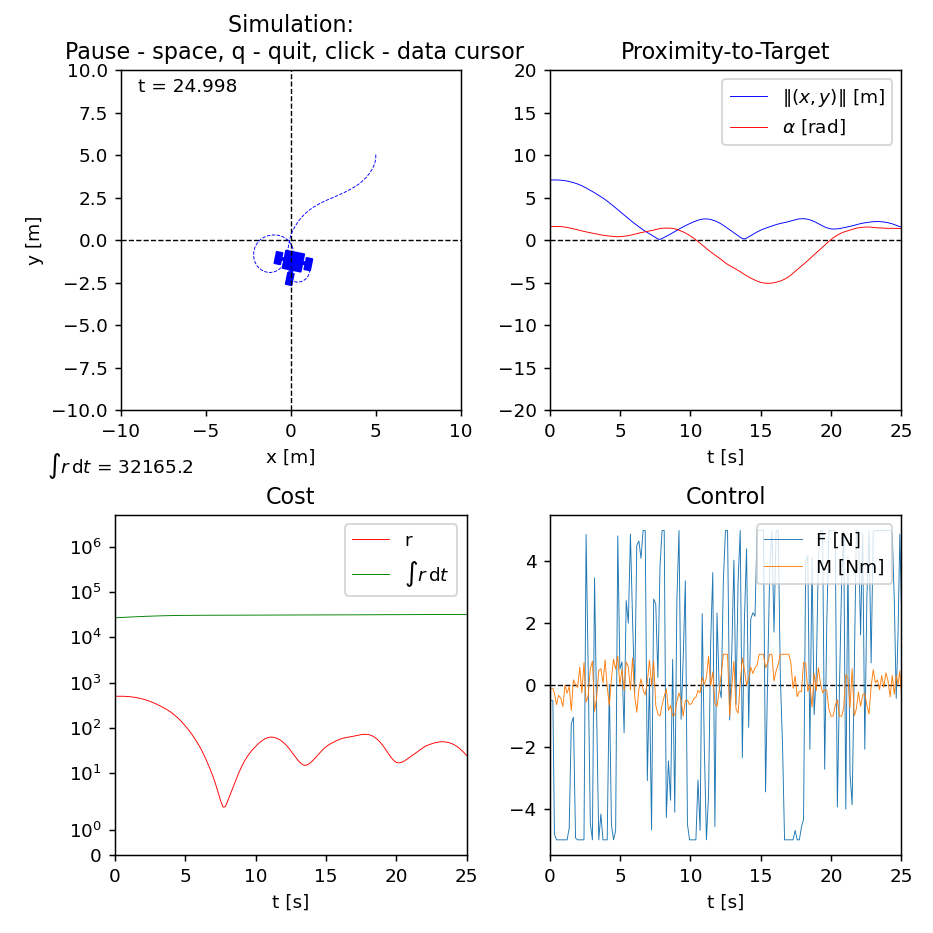

<IPython.core.display.HTML object>

In [63]:
# # Uncomment to visualize
%matplotlib notebook
HTML(sim.run_simulation(n_runs=3, fig_width=7, fig_height=7))

### Take notice

The epsilon $\epsilon$ hyperparameter dictates the probability that a random action is selected as policy. 

Because Sarsa is **on-policy** -- then given a) non-zero $\epsilon$ and b) over-repeated trials, it's Q-function will take more updates/steps to reach optimality than an algorithm that uses the maximum Q-value for the Q-function update, like *Q-learning* (which we review next).

As Sutton states:
> * The convergence properties of the Sarsa algorithm depend on the nature of the policy’s dependence on Q. For example, one could use "-greedy or "-soft policies. 
> * Sarsa converges with probability 1 to an optimal policy and action-value function as long as all state–action pairs are visited an infinite number of times and the policy converges in the limit to the greedy policy (which can be arranged, for example, with "-greedy policies by setting " = 1/t).

### <font color="orange">Auto-grading</font>
Run this cell to track your answers.

In [66]:
### GRADING DO NOT MODIFY
statistics, = sim.final_statistics

hw3_answers.record('problem_3-1', 
    {'mean_rc': statistics[0],
    'mean_velocity': statistics[1], 
    'sd_rc': statistics[2],
    'sd_velocity': statistics[3],
    'sd_alpha': statistics[4],
    'final_l2_norm': statistics[5],
    'sd_l2_norm': statistics[6],
    'rmse_l2_norm': statistics[7]})

### <font color="blue">Problem 3.2 - Q-Learning</font>

Q-learning is an <font color="8F00FF">**off-policy**</font> TD algorithm that has only a minor (but important) variation compared to Sarsa <sup>[1]</sup>:
> In this case, the learned action-value function, Q, directly approximates $q_{*}$, the optimal action-value function, independent of the policy being followed.

Note that "the policy still has an effect in that it determines which state–action pairs are visited and updated", but the Q-value of the next state is always the maximum value over all possible actions. In the **finite** MDP case, the Q-update becomes <sup>[1]</sup>:

$$Q\left(S_{t}, A_{t}\right) \leftarrow Q\left(S_{t}, A_{t}\right)+\alpha\left[R_{t+1}+\gamma \max _{a} Q\left(S_{t+1}, a\right)-Q\left(S_{t}, A_{t}\right)\right]$$

The algorithm outline in the **finite MDP** case is:

<img src="qlearning_sutton.png" width=70% height=70% />

Similar to Sarsa, the following Q-learning algorithm is adapted to the **continuous, linear approximation** case:

<img src="QlearningC.png" width=70% height=70% />

#### Execute the code below and compare it to Sarsa
* Make sure you're clear on the difference in these algorithms
* Note that we're using the epsilon of `0.3`
* There's nothing for you to do on this one - just make sure you know how it works

In [67]:
class QLearning(SARSA):
    def __init__(self, system, **kwargs):
        super(QLearning, self).__init__(system, **kwargs)

    def compute_action(self, t, x_current):
        time_since_last_action = t - self.ctrl_clock

        if time_since_last_action >= self.sample_time:
            
            self.q_fn.eval()
            
            # line 3
            u_current = self.u_curr

            # line 5
            x_next = self._take_action(x_current, u_current)
            
            # line 6
            u_next, u_best = self._policy_mc(x_next)

            # line 7: step 1
            """
                Remember that the policy_mc is epsilon-greedy. Sometimes it outputs a random action. When this is the case, we still take the maximum value action and use it in the td calculation.
            """
            # if a random action was *not* selected
            if u_best is None:
                # then `u_next` is best action: use it for td calculation
                u_best = u_next

            # line 7: step 2
            td = self._temporal_diff(u_current, x_current, u_best, x_next)

            # Q-function update starts here
            self.q_fn.train()
            self.optimizer.zero_grad()

            # line 8
            td.backward()
            self.optimizer.step()
            # Q-function update ends here

            self.u_curr = u_next

            return self.u_curr

        else:
            return self.u_curr

### Create sys, agent, sim

In [68]:
sys = EndiSystem()
agent5 = QLearning(sys, sample_time=0.3, horizon_length=10, epsilon=0.3, t1=25)
sim = Simulation(sys, agent5)

### Run sim (non-visual)
* If running multiple times, be sure to re-instantiate the agent above to re-initialize its NN weights.

In [69]:
sim.run_simulation(n_runs=3, 
            is_visualization=False, 
            exit_py_on_finish=False, 
            show_annotations=True, 
            show_summary_stats=True, 
            print_statistics_at_step=False)

... Running - run 1...
... Running - run 2...
... Running - run 3...
Total runs for each controller: 3
Statistics for controller 1:
            - Mean of running cost: 75.33
            - Mean of velocity: -0.24
            - SD of running cost: 150.06
            - SD of velocity: 0.56
            - SD of turning angle: 75.33
            - SD L2-norm: 2.17
            - Final L2-norm: 0.36
            - RMSE of Trajectory: 3.244
                


#### Option to visualize

In [ ]:
# # Uncomment to visualize
# %matplotlib notebook
# HTML(sim.run_simulation(n_runs=3, fig_width=7, fig_height=7))

### Analysis

What do you think- over **a large number of simulations**, for a non-zero $\epsilon$, which algorithm should produce better performance: Sarsa or Q-learning? Even in the limited simulations above, keeping all variables fixed, Sarsa algorithm *tends* to have a bit higher RMSE of Trajectory than Q-learning (though again, this is not guaranteed because of the e-greedy policy). This means that in the sims above, Sarsa tends to have a less linear path towards (0,0) xy-coords. 

Q-learning is guaranteed to converge to the optimal Q-function over infinite iterations. Per Sutton:
> * In this case, the learned action-value function, Q, directly approximates $q_{*}$, the optimal action-value function, independent of the policy being followed. This dramatically simplifies the analysis of the algorithm and enabled early convergence proofs. The policy still has an effect in that it determines which state–action pairs are visited and updated. However, all that is required for correct convergence is that all pairs continue to be updated. As we observed in Chapter 5, this is a minimal requirement in the sense that any method guaranteed to find optimal behavior in the general case must require it. 
> * <font color="green">Under this assumption and a variant of the usual stochastic approximation conditions on the sequence of step-size parameters, Q has been shown to converge with probability 1 to $q_{*}$.</font>

### <font color="orange">Auto-grading</font>
Run this cell to track your answers.

In [70]:
### GRADING DO NOT MODIFY
statistics, = sim.final_statistics

hw3_answers.record('problem_3-2', 
    {'mean_rc': statistics[0],
    'mean_velocity': statistics[1], 
    'sd_rc': statistics[2],
    'sd_velocity': statistics[3],
    'sd_alpha': statistics[4],
    'final_l2_norm': statistics[5],
    'sd_l2_norm': statistics[6],
    'rmse_l2_norm': statistics[7]})

### <font color="orange">Auto-grading: Submit your answers</font>
Enter your first and last name in the cell below **precisely as it appears in Canvas**, and then run the cell to save your answers to a JSON file. Failure to enter your name exactly as it appears in Canvas will result in failed grade, as you will be giving the autograder incorrect information with which to record grades. After the JSON file is created, upload it to the assignment page on Canvas.

In [71]:
hw3_answers.print_answers()

{'problem_1-1': {'mean_rc': 57.85, 'mean_velocity': -0.23, 'sd_rc': 141.12, 'sd_velocity': 0.55, 'sd_alpha': 57.85, 'final_l2_norm': 0.04, 'sd_l2_norm': 2.13, 'rmse_l2_norm': 3.365}, 'problem_2-1': {'mean_rc': 60.76, 'mean_velocity': -0.23, 'sd_rc': 144.28, 'sd_velocity': 0.53, 'sd_alpha': 60.76, 'final_l2_norm': 0.0, 'sd_l2_norm': 2.19, 'rmse_l2_norm': 3.373}, 'problem_2-2': {'mean_rc': 81.24, 'mean_velocity': -0.33, 'sd_rc': 160.82, 'sd_velocity': 0.61, 'sd_alpha': 81.24, 'final_l2_norm': 0.02, 'sd_l2_norm': 2.4, 'rmse_l2_norm': 3.324}, 'problem_3-1': {'mean_rc': 93.48, 'mean_velocity': -0.17, 'sd_rc': 159.94, 'sd_velocity': 0.51, 'sd_alpha': 93.48, 'final_l2_norm': 0.21, 'sd_l2_norm': 2.38, 'rmse_l2_norm': 2.91}, 'problem_3-2': {'mean_rc': 75.33, 'mean_velocity': -0.24, 'sd_rc': 150.06, 'sd_velocity': 0.56, 'sd_alpha': 75.33, 'final_l2_norm': 0.36, 'sd_l2_norm': 2.17, 'rmse_l2_norm': 3.244}}


In [72]:
assignment_name = "hw_3"
first_name = "NAME" # Use proper capitalization
last_name = "SURNAME" # Use proper capitalization

hw3_answers.save_to_json(assignment_name, first_name, last_name)

### Questions?

Reach out to your instructors on Piazza.

### Sources

***

<sup>[1]</sup> Sutton, R., & Barto, A. (1998). Introduction to Reinforcement Learning.